# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,UpSampling2D,Concatenate,Input,Softmax
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
EPOCHS=10
BATCH_SIZE=10
HEIGHT=256
WIDTH=256
N_CLASSES=13

# Utility Functions

In [ ]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)

    image = img[:,:256]
    mask = img[:,256:]

    return image, mask


def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

def getSegmentationArr(image, classes, width=WIDTH, height=HEIGHT):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

def give_color_to_seg_img(seg, n_classes=N_CLASSES):

    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)

    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

classes = 13

# Dataset

In [ ]:
train_folder = "../input/cityscapes-image-pairs/cityscapes_data/train"
valid_folder = "../input/cityscapes-image-pairs/cityscapes_data/val"

num_of_training_samples = len(os.listdir(train_folder))
num_of_valid_samples = len(os.listdir(valid_folder))

def DataGenerator(path, batch_size=BATCH_SIZE, classes=N_CLASSES):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                image, mask = LoadImage(file, path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

In [ ]:
train_gen = DataGenerator(train_folder, batch_size=BATCH_SIZE)
val_gen = DataGenerator(valid_folder, batch_size=BATCH_SIZE)

In [ ]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((10, 256, 256, 3), (10, 256, 256, 13))

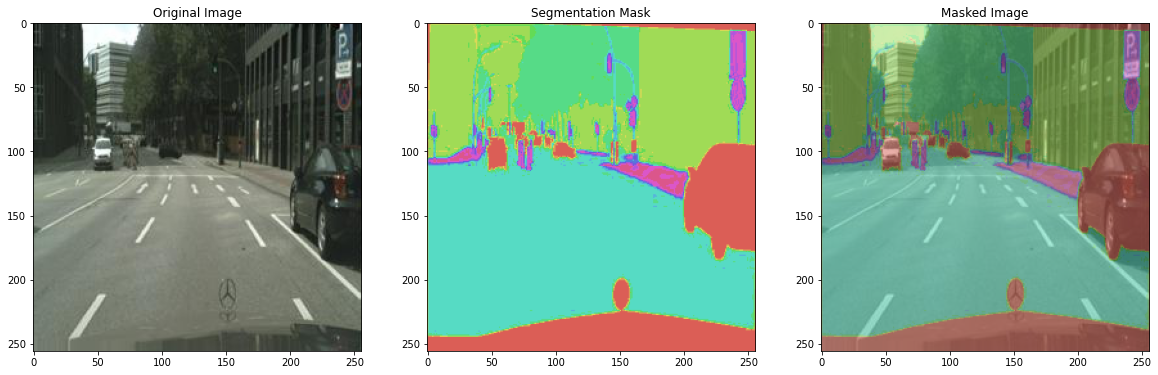

In [ ]:
image = imgs[0]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
#predimg = cv2.addWeighted(imgs[i]/255, 0.6, _p, 0.4, 0)
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plt.show()

# Model

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((HEIGHT,WIDTH,3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    outputs = Conv2D(13, (1, 1), padding="same", activation="sigmoid")(u4)
    model = Model(inputs, outputs)
    return model

In [ ]:
checkpoint = ModelCheckpoint('seg_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# Training

In [ ]:
TRAIN_STEPS = num_of_training_samples//BATCH_SIZE+1
VAL_STEPS = num_of_valid_samples//BATCH_SIZE+1

model.fit_generator(train_gen, validation_data=val_gen, steps_per_epoch=TRAIN_STEPS,
                    validation_steps=VAL_STEPS, epochs=EPOCHS, callbacks = checkpoint)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
298/298 [==============================] - 114s 359ms/step - loss: 2.2766 - acc: 0.4332 - val_loss: 1.2133 - val_acc: 0.6611

Epoch 00001: val_acc improved from -inf to 0.66111, saving model to seg_model.hdf5
Epoch 2/10
298/298 [==============================] - 105s 353ms/step - loss: 1.1062 - acc: 0.6882 - val_loss: 1.0286 - val_acc: 0.7064

Epoch 00002: val_acc improved from 0.66111 to 0.70638, saving model to seg_model.hdf5
Epoch 3/10
298/298 [==============================] - 105s 353ms/step - loss: 0.9428 - acc: 0.7347 - val_loss: 0.9300 - val_acc: 0.7382

Epoch 00003: val_acc improved from 0.70638 to 0.73815, saving model to seg_model.hdf5
Epoch 4/10
298/298 [==============================] - 105s 353ms/step - loss: 0.8565 - acc: 0.7625 - val_loss: 0.8691 - val_acc: 0.7551

Epoch 00004: val_acc improved from 0.73815 to 0.75512, saving model to seg_model.hdf5
Epoch 5/10
298/298 [==============================] - 105s 353ms/step - loss: 0.8001 - acc: 0.7765 - val_loss: 

In [ ]:
model.load_weights("./seg_model.hdf5")

In [ ]:
loss = history.history["val_loss"]
acc = history.history["val_acc"]

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(acc)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
#plot.savefig("learn.png", dpi=150)
plot.show()

NameError: name 'history' is not defined

# Validation

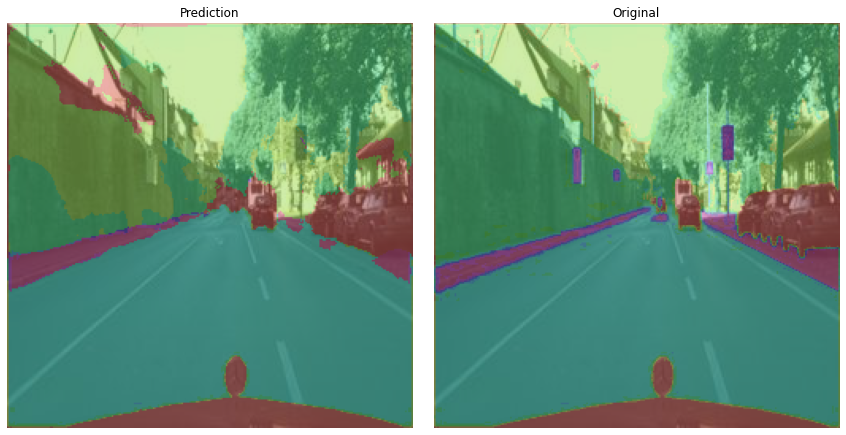

In [ ]:
max_show = 1
imgs, segs = next(val_gen)
pred = model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)

    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.title("Prediction")
    plt.imshow(predimg)
    plt.axis("off")
    plt.subplot(122)
    plt.title("Original")
    plt.imshow(trueimg)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("pred_"+str(i)+".png", dpi=150)
    plt.show()